
# DP Rebalancing with Mean–Variance Risk Penalty

This notebook demonstrates a **dynamic programming (DP) portfolio rebalancing** framework with transaction costs and a **mean–variance risk penalty**.


In [1]:

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List

np.set_printoptions(precision=4, suppress=True)
%matplotlib inline


In [2]:

@dataclass
class Config:
    start: str = "2015-01-01"
    end: str = "2025-01-01"
    train_end: str = "2022-12-31"
    mom_win: int = 20
    vol_win: int = 20
    nbins: int = 3
    partitions: int = 4
    gamma: float = 0.995
    tc: float = 0.001
    min_obs_per_state: int = 20
    seed: int = 7
    lambda_risk: float = 1.0
    sigma_shrink: float = 0.2
    weight_grid: np.ndarray = field(default_factory=lambda: np.array([[0.5, 0.5]], dtype=float))

CFG = Config()


In [3]:

def read_user_tickers(default=("SPY", "TLT")) -> List[str]:
    return list(default)

def build_simplex_grid(n_assets: int, partitions: int) -> np.ndarray:
    def compositions(m, n):
        if n == 1:
            yield (m,)
            return
        for k in range(m+1):
            for rest in compositions(m-k, n-1):
                yield (k,) + rest
    return np.array([np.array(comp, float)/partitions for comp in compositions(partitions, n_assets)], float)

def load_price_data(tickers, start, end):
    px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(px, pd.Series):
        px = px.to_frame(tickers[0])
    return px.dropna().astype(float)

def make_features(px: pd.DataFrame, proxy: str, mom_win: int, vol_win: int):
    rets = np.log(px).diff().dropna()
    mom = rets[proxy].rolling(mom_win).sum()
    vol = rets[proxy].rolling(vol_win).std()
    X = pd.DataFrame({"mom": mom, "vol": vol}).dropna()
    return rets.loc[X.index], X

def discretize_states(mom: pd.Series, vol: pd.Series, nbins: int):
    m = pd.qcut(mom, q=nbins, labels=False, duplicates="drop")
    v = pd.qcut(vol, q=nbins, labels=False, duplicates="drop")
    idx = m.dropna().index.intersection(v.dropna().index)
    state = (m.loc[idx].astype(int)*nbins + v.loc[idx].astype(int)).astype(int)
    return pd.Series(state, index=idx, name="state"), nbins*nbins

def estimate_transition_matrix(state_id: pd.Series, S: int) -> np.ndarray:
    P = np.zeros((S,S), float)
    sid = state_id.values
    for t in range(len(sid)-1):
        P[sid[t], sid[t+1]] += 1
    row = P.sum(axis=1, keepdims=True)
    P = np.divide(P, row, where=(row!=0))
    for s in range(S):
        if P[s].sum()==0: P[s,s]=1.0
    return P

def mu_sigma_by_state(rets, state_id, S, min_obs=20, shrink=0.2):
    r_next = rets.shift(-1).loc[state_id.index]
    df = pd.concat([state_id, r_next], axis=1).dropna()
    cols = rets.columns
    N = len(cols)
    mu = np.zeros((S,N))
    Sig = [np.eye(N)*1e-6 for _ in range(S)]
    mu_g = df[cols].mean().values if len(df) else np.zeros(N)
    Sig_g = np.cov(df[cols].values.T) if len(df) else np.eye(N)*1e-4
    if np.ndim(Sig_g)==0: Sig_g=np.array([[Sig_g]])
    for s in range(S):
        tmp = df[df["state"]==s][cols]
        if len(tmp)>=min_obs:
            mu_s = tmp.mean().values
            C = np.cov(tmp.values.T)
        else:
            mu_s = mu_g; C = Sig_g
        diag = np.diag(np.diag(C))
        C_sh = (1-shrink)*C + shrink*diag + np.eye(N)*1e-10
        mu[s]=mu_s; Sig[s]=C_sh
    return mu, Sig

def risk_adjusted_rewards_meanvar(mu_state, Sig_list, weight_grid, lam=1.0):
    S = mu_state.shape[0]; W = weight_grid.shape[0]
    rew = np.zeros((S,W))
    for s in range(S):
        mu_s = mu_state[s]; Sig = Sig_list[s]
        mean_part = weight_grid @ mu_s
        var_part = np.einsum('ij,jk,ik->i', weight_grid, Sig, weight_grid)
        rew[s] = mean_part - 0.5*lam*var_part
    return rew

def bellman_rebalance_with_rew(P, rew, weight_grid, gamma=0.995, tc=0.001, tol=1e-8, maxit=10000):
    S,W = P.shape[0], weight_grid.shape[0]
    V=np.zeros((S,W)); policy=np.zeros((S,W),dtype=int)
    for _ in range(maxit):
        EV = P @ V
        Vn=np.empty_like(V); poln=np.empty_like(policy)
        for s in range(S):
            for i in range(W):
                turnover = np.abs(weight_grid-weight_grid[i]).sum(axis=1)
                obj = rew[s]-tc*turnover+gamma*EV[s]
                j=int(np.argmax(obj))
                Vn[s,i]=obj[j]; poln[s,i]=j
        if np.max(np.abs(Vn-V))<tol: return Vn,poln
        V,policy=Vn,poln
    return V,policy

def simulate_policy(rets, state_id, weight_grid, policy, tc=0.001):
    idx=state_id.index; r=rets.loc[idx].shift(-1)
    i_idx=0; eq=1.0; rows=[]
    for t in range(len(idx)-1):
        s=int(state_id.iloc[t]); j=int(policy[s,i_idx])
        w_old,w_new=weight_grid[i_idx],weight_grid[j]
        turn=np.abs(w_new-w_old).sum()
        r_p=float(w_new @ r.iloc[t].values)-tc*turn
        eq*=(1+r_p); rows.append((idx[t+1],eq,j,s))
        i_idx=j
    return pd.DataFrame(rows,columns=["date","equity","weight_idx","state"]).set_index("date")

def equal_weight_benchmark(rets):
    eq_ret=rets @ (np.ones(rets.shape[1])/rets.shape[1])
    return (1+eq_ret).cumprod().rename("equal_weight")


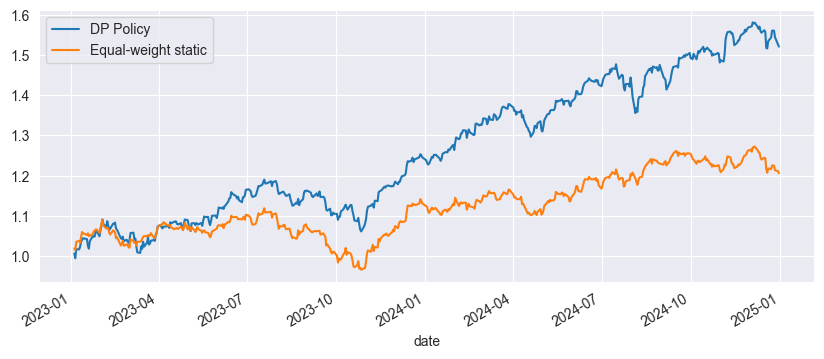

In [4]:

def run():
    tickers = read_user_tickers()
    CFG.weight_grid = build_simplex_grid(len(tickers), CFG.partitions)
    px=load_price_data(tickers, CFG.start, CFG.end)
    rets,X=make_features(px,proxy=tickers[0],mom_win=CFG.mom_win,vol_win=CFG.vol_win)
    idx=rets.index.intersection(X.index)
    rets=rets.loc[idx]; X=X.loc[idx]
    train_mask=idx<=CFG.train_end; test_mask=idx>CFG.train_end
    st_tr,S=discretize_states(X["mom"].loc[train_mask],X["vol"].loc[train_mask],CFG.nbins)
    st_all,_=discretize_states(X["mom"],X["vol"],CFG.nbins)
    st_te=st_all.loc[test_mask]
    P=estimate_transition_matrix(st_tr,S)
    mu,Sig=mu_sigma_by_state(rets.loc[train_mask],st_tr,S,CFG.min_obs_per_state,CFG.sigma_shrink)
    rew=risk_adjusted_rewards_meanvar(mu,Sig,CFG.weight_grid,lam=CFG.lambda_risk)
    V,policy=bellman_rebalance_with_rew(P,rew,CFG.weight_grid,CFG.gamma,CFG.tc)
    equity_df=simulate_policy(rets.loc[test_mask],st_te,CFG.weight_grid,policy,CFG.tc)
    bench=equal_weight_benchmark(rets.loc[test_mask]).reindex(equity_df.index,method="pad")
    ax=equity_df["equity"].plot(figsize=(10,4),label="DP Policy")
    bench.plot(ax=ax,label="Equal-weight static")
    ax.legend(); plt.show()

run()



## Extra: Active NAV (DP Policy vs Equal-weight)

This cell computes the **relative performance** of the DP Policy compared to the equal-weight benchmark, i.e. `Policy / Benchmark`.  
It shows how much better the DP strategy performed, and prints key active performance metrics (alpha, active volatility, hit ratio, max drawdown).


In [5]:

# Redefine run() to RETURN equity_df and bench so downstream cells can use them
def run():
    tickers = read_user_tickers()
    CFG.weight_grid = build_simplex_grid(len(tickers), CFG.partitions)
    px = load_price_data(tickers, CFG.start, CFG.end)
    rets, X = make_features(px, proxy=tickers[0], mom_win=CFG.mom_win, vol_win=CFG.vol_win)

    # align & split
    idx = rets.index.intersection(X.index)
    rets = rets.loc[idx]; X = X.loc[idx]
    train_mask = idx <= CFG.train_end
    test_mask  = idx >  CFG.train_end

    # states
    st_tr, S = discretize_states(X["mom"].loc[train_mask], X["vol"].loc[train_mask], CFG.nbins)
    st_all, _ = discretize_states(X["mom"], X["vol"], CFG.nbins)
    st_te = st_all.loc[test_mask]

    # transitions (train)
    P = estimate_transition_matrix(st_tr, S)

    # μ(s), Σ(s) (train)
    mu, Sig = mu_sigma_by_state(rets.loc[train_mask], st_tr, S,
                                min_obs=CFG.min_obs_per_state,
                                shrink=CFG.sigma_shrink)

    # risk-adjusted rewards
    rew = risk_adjusted_rewards_meanvar(mu, Sig, CFG.weight_grid, lam=CFG.lambda_risk)

    # Bellman
    V, policy = bellman_rebalance_with_rew(P, rew, CFG.weight_grid,
                                           gamma=CFG.gamma, tc=CFG.tc)

    # backtest
    equity_df = simulate_policy(rets.loc[test_mask], st_te, CFG.weight_grid, policy, CFG.tc)
    bench = equal_weight_benchmark(rets.loc[test_mask]).reindex(equity_df.index, method="pad")

    # plot
    ax = equity_df["equity"].plot(figsize=(10, 4), label="DP Policy (mean-variance)")
    bench.plot(ax=ax, label="Equal-weight static")
    ax.set_title("Equity Curve (Test)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return equity_df, bench


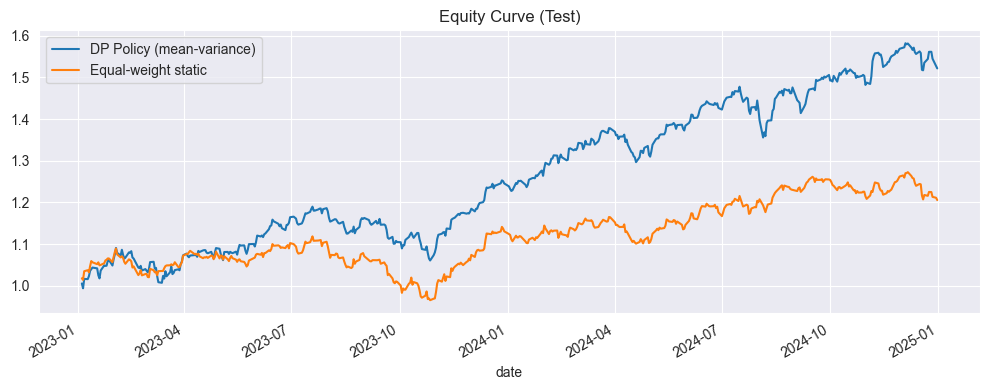

In [6]:

# Execute pipeline and capture key outputs for downstream analysis
equity_df, bench = run()


=== Active Performance Metrics ===
Annualized Alpha:  12.5066%
Active Vol (ann.):  9.01%
Hit Ratio:  56.09%
Max Active Drawdown: -6.77%


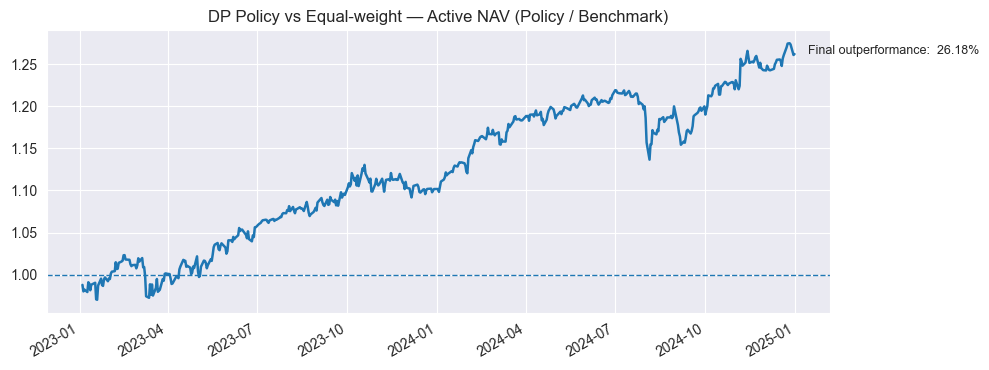

In [7]:

df = pd.DataFrame({
    "policy": equity_df["equity"],
    "bench": bench
}).dropna()

# Relative NAV: Policy vs Benchmark
active_nav = (df["policy"] / df["bench"]).rename("Active NAV (Policy / Benchmark)")

# Active return stats
active_ret = df["policy"].pct_change().fillna(0) - df["bench"].pct_change().fillna(0)
ann_alpha = active_ret.mean() * 252
ann_vol_ex = active_ret.std() * np.sqrt(252)
hit_ratio = (active_ret > 0).mean()
max_active_dd = (active_nav / active_nav.cummax() - 1).min()

print("=== Active Performance Metrics ===")
print(f"Annualized Alpha: {ann_alpha: .4%}")
print(f"Active Vol (ann.): {ann_vol_ex: .2%}")
print(f"Hit Ratio: {hit_ratio: .2%}")
print(f"Max Active Drawdown: {max_active_dd: .2%}")

# Plot Active NAV
ax2 = active_nav.plot(figsize=(10, 3.8), lw=1.8)
ax2.axhline(1.0, linestyle="--", linewidth=1)
final_outperf = active_nav.iloc[-1] - 1
ax2.set_title("DP Policy vs Equal-weight — Active NAV (Policy / Benchmark)")
ax2.set_xlabel("")
ax2.annotate(f"Final outperformance: {final_outperf: .2%}",
             xy=(active_nav.index[-1], active_nav.iloc[-1]),
             xytext=(10, 0),
             textcoords="offset points",
             fontsize=9)
plt.tight_layout()
plt.show()
